<a href="https://colab.research.google.com/github/gacerioni/redis-workshop-mensageria-pubsub-streams/blob/master/redis_workshop_mensageria_pubsub_streams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workshop - Mensageria com Listas, Pub/Sub e Streams

![Redis](https://redis.io/wp-content/uploads/2024/04/Logotype.svg?auto=webp&quality=85,75&width=120)


Bem-vind[ao]s ao Workshop! Vamos explorar como utilizar o Redis para mensageria e comunicação eficiente entre serviços. Vamos começar com o conceito de filas, avançando para Pub/Sub e Streams.

Para uma experiência premium, como a que eu quero que vocês tenham, recomendo MUITO utilizar o Redis Insight (App ou Web) pra apoiar na visualização dos dados.

https://redis.com/redis-enterprise/redis-insight/

## Objetivos do Workshop

Este notebook irá fazer uma introdução ao uso de listas no Redis para implementar filas de mensagens. Em seguida, exploraremos o Pub/Sub e Streams para comunicação em tempo real e processamento de dados.



Espero que gostem! 🖖

## Setup Rápido - e testes pra ver se tá tudo redondo antes de iniciar o lab

In [12]:
# Vamos instalar a lib do redis escolhida para o teste
!pip install -q redis

# E instalar a CLI, via redis-tools, que inclui a famosa redis-cli
!apt-get update
!apt-get install -y redis-tools

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
redis-tools is already the newest version (5:6.0.16-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 53 not upgraded.


#### Configurando e testando a conexão com o seu Redis Cloud

Coloque o endpoint host, port, e as credenciais pertinentes ao seu setup.

Vou deixar o meu DB mesmo aqui, como referência.

In [13]:
# Testando a redis-cli
import os

# Coloque aqui os dados do seu DB do Redis Cloud
REDIS_HOST="redis-19581.c308.sa-east-1-1.ec2.redns.redis-cloud.com"
REDIS_PORT=19581
REDIS_PASSWORD="nhtuquVSLbh2kUt2I86z5QwGu3KrcaYx"

# Caso o SSL esteja ativo pro endpoint, adicione --tls
# Recomendo não misturar lé com cré aqui, visto que não vamos ter nenhuma informação sensível passando pelo fio.
if REDIS_PASSWORD!="":
  os.environ["REDIS_CONN"]=f"-h {REDIS_HOST} -p {REDIS_PORT} -a {REDIS_PASSWORD} --no-auth-warning"
else:
  os.environ["REDIS_CONN"]=f"-h {REDIS_HOST} -p {REDIS_PORT}"

# Caso o SSL esteja ativo pro endpoint, use rediss:// como o URL prefix
REDIS_URL = f"redis://:{REDIS_PASSWORD}@{REDIS_HOST}:{REDIS_PORT}"
INDEX_NAME = f"qna:idx"

# Test a Redis connection
!redis-cli $REDIS_CONN PING

# DANGER ZONE - CASO QUEIRA DAR UM REFRESH GERAL
# este comando abaixo ficará comentado, pois ele deleta todos os dados da sua base do Redis Cloud
!redis-cli $REDIS_CONN FLUSHDB

PONG
OK


In [14]:
# Testando via Python (redis-py)
import redis
r = redis.Redis(
  host=REDIS_HOST,
  port=REDIS_PORT,
  password=REDIS_PASSWORD,
  decode_responses=True)
r.ping()

True

# Parte Um - Introdução às Filas no Redis

**Filas são uma estrutura de dados fundamental para a comunicação assíncrona entre serviços.**\

Em ciência da computação, uma fila é uma coleção de entidades mantidas em uma sequência, onde elementos são adicionados em uma extremidade da sequência e removidos da outra. Esta característica é conhecida como FIFO (First In, First Out), o que significa que o primeiro elemento adicionado à fila é o primeiro a ser removido.

Filas são amplamente utilizadas na programação para organizar tarefas de forma sequencial. Um exemplo moderno é um sistema de venda de ingressos de futebol, onde os pedidos são enfileirados e processados na ordem em que são recebidos, garantindo que cada cliente receba seu ingresso corretamente e na sequência certa.


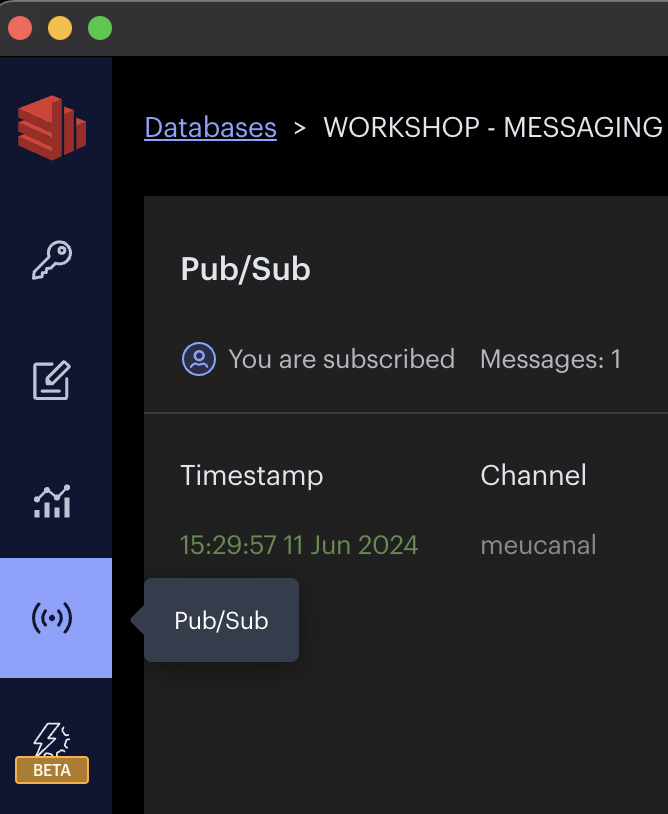## Criando uma Fila no Redis

No Redis, usamos listas para implementar filas. Vamos começar criando uma fila e adicionando algumas mensagens.

In [15]:
# Deletar a fila caso já exista, só pra não confundir a gente
r.delete("minhafila")

# Adicionar elementos à fila (enqueue)
r.lpush("minhafila", "Tarefa 1")
r.lpush("minhafila", "Tarefa 2")
r.lpush("minhafila", "Tarefa 3")
r.lpush("minhafila", "Tarefa 4")
r.lpush("minhafila", "Tarefa 5")

# Verificar os elementos na fila
print(r.lrange("minhafila", 0, -1))

['Tarefa 5', 'Tarefa 4', 'Tarefa 3', 'Tarefa 2', 'Tarefa 1']


Neste exemplo, usamos o comando LPUSH para adicionar elementos à fila chamada "minhafila". Verificamos os elementos na fila usando o comando LRANGE, que retorna todos os elementos da lista.

## Consumo de Mensagens/Elementos da Fila  (Dequeue)

Depois de adicionar mensagens à fila, precisamos consumir essas mensagens para processá-las.

O Redis oferece o comando `RPOP` para remover e retornar o último elemento da lista, seguindo a ordem **FIFO** (first-in-first-out)

In [16]:
# Remover e consumir o próximo elemento da fila (dequeue)
mensagem = r.rpop("minhafila")
print(f"Mensagem consumida: {mensagem}")

# Verificar os elementos restantes na fila
print(r.lrange("minhafila", 0, -1))

# execute algumas vezes, para vc entender como a fila está sendo consumida e exaurida ao mesmo tempo

Mensagem consumida: Tarefa 1
['Tarefa 5', 'Tarefa 4', 'Tarefa 3', 'Tarefa 2']


### 🤓 Vamos adicionar um exemplo mais prático e interessante!

Imagine que estamos processando pedidos de ingressos para um jogo de futebol. Cada mensagem na fila representa um pedido de ingresso que precisa ser processado.

In [17]:
import time
# Populando nossa lista com alguns pedidos de tickets novos
r.lpush("tickets:futeborrrr:fila", "Pedido 1",  "Pedido 2",  "Pedido 3",  "Pedido 4",  "Pedido 5",  "Pedido 6")

##### INICIO DO ROBOZINHO SIMPLES QUE PROCESSA OS PEDIDOS

# Processar pedidos de ingressos
def processar_pedido(pedido):
    time.sleep(0.5)
    print(f"Processando pedido: {pedido}")

# Consumir e processar mensagens na fila
while True:
    pedido = r.rpop("tickets:futeborrrr:fila")
    if not pedido:
        print("Nenhum pedido pendente.")
        break
    processar_pedido(pedido)

# Verificar os elementos restantes na fila
print(r.lrange("tickets:futeborrrr:fila", 0, -1))


Processando pedido: Pedido 1
Processando pedido: Pedido 2
Processando pedido: Pedido 3
Processando pedido: Pedido 4
Processando pedido: Pedido 5
Processando pedido: Pedido 6
Nenhum pedido pendente.
[]


Neste código, definimos uma função processar_pedido que simula o processamento de um pedido. Em seguida, usamos um loop para consumir e processar todas as mensagens na fila "minhafila" até que ela esteja vazia.

Com isso, você aprendeu a consumir mensagens de uma fila no Redis, removendo e processando cada mensagem na ordem correta. Vamos continuar com os próximos passos, como visualizar (peek) e implementar filas confiáveis, em blocos subsequentes.

## Visualizando os elementos da fila (Peek)

A operação de "peek" permite visualizar os elementos na fila sem removê-los. Isso pode ser útil para verificar o próximo item a ser processado ou para inspecionar o estado atual da fila.



In [21]:
fila = "tickets:futeborrrr:filapeek"

# Popular uma fila pra testar o peek
r.lpush(fila, "Pedido 1",  "Pedido 2",  "Pedido 3",  "Pedido 4",  "Pedido 5",  "Pedido 6")

# Visualizar o próximo elemento da fila (peek)
proximo_elemento = r.lrange(fila, -1, -1)
print(f"Próximo elemento a ser processado: {proximo_elemento}")

# Visualizar os três últimos elementos da fila
tres_ultimos_elementos = r.lrange(fila, -3, -1)
print(f"Três últimos elementos na fila: {tres_ultimos_elementos}")

# Visualizar todos os elementos na fila
todos_elementos = r.lrange(fila, 0, -1)
print(f"Todos os elementos na fila: {todos_elementos}")

Próximo elemento a ser processado: ['Pedido 1']
Três últimos elementos na fila: ['Pedido 3', 'Pedido 2', 'Pedido 1']
Todos os elementos na fila: ['Pedido 6', 'Pedido 5', 'Pedido 4', 'Pedido 3', 'Pedido 2', 'Pedido 1', 'Pedido 6', 'Pedido 5', 'Pedido 4', 'Pedido 3', 'Pedido 2', 'Pedido 1', 'Pedido 6', 'Pedido 5', 'Pedido 4', 'Pedido 3', 'Pedido 2', 'Pedido 1']


## Implementando Filas Confiáveis

Para garantir que mensagens não sejam perdidas se um consumidor falhar, podemos implementar filas confiáveis no Redis. Isso envolve mover as mensagens para uma fila temporária até que o processamento seja confirmado.

### Pegar uma mensagem/elemento da fila para processar, enquanto a move para uma fila temporária - como uma triagem

In [46]:
# Use este bloco para iniciar ou resetar as filas deste exercicio
r.delete("tickets:counterstrike2:fila_primaria")
r.delete("tickets:counterstrike2:fila_temporaria")
r.lpush("tickets:counterstrike2:fila_primaria", "Pessoa 1", "Pessoa 2", "Pessoa 3", "Pessoa 4", "Pessoa 5")

5

In [47]:
# Aqui já pegamos uma mensagem para processar, enquanto a movemos da fila principal para uma fila temporária
mensagem_a_ser_processada = r.rpoplpush("tickets:counterstrike2:fila_primaria", "tickets:counterstrike2:fila_temporaria")

print("Elemento da fila que será processado: {0}".format(mensagem_a_ser_processada))

Elemento da fila que será processado: Pessoa 1


In [48]:
# E o elemento fica na temporaria enquanto o servico esta fazendo o que precisa fazer
r.lrange("tickets:counterstrike2:fila_temporaria", 0, -1)

['Pessoa 1']

### Confirmar o Processamento de uma Mensagem
Caso esteja tudo certo, você vai e apaga a mensagem da fila temporária, finalizando a triagem.



In [45]:
# Após processar a mensagem, removê-la da fila temporária
r.lrem("tickets:counterstrike2:fila_temporaria", 1, mensagem_a_ser_processada)

1

# Parte Dois - Vamos ver o Pub/Sub no Redis

## Introdução ao Pub/Sub no Redis

O padrão Publish/Subscribe (Pub/Sub) no Redis é uma poderosa ferramenta de mensageria que permite a comunicação eficiente entre serviços. Diferente de filas tradicionais, onde mensagens são enviadas diretamente de um produtor para um consumidor, o Pub/Sub permite que mensagens sejam publicadas em canais específicos e consumidas por múltiplos assinantes. Isso é especialmente útil em cenários onde a mesma mensagem precisa ser entregue a vários consumidores simultaneamente, como em sistemas de notificações em tempo real.

Neste tutorial, aprenderemos como configurar e usar o Pub/Sub no Redis. Começaremos com exemplos simples de publicação e consumo de mensagens, e avançaremos para um caso de uso mais complexo com múltiplos consumidores. Através de exercícios práticos, você entenderá como o Pub/Sub pode ser utilizado para criar sistemas de comunicação escaláveis e desacoplados.

## Configurando Pub/Sub no Redis

Vamos com um exemplo simples de Pub/Sub, onde um produtor publica mensagens em um canal e um consumidor se inscreve para receber essas mensagens.

🔊 Bem na pegada fire-and-forget: não estava lá pra ouvir... perdeu!\
*E isso é o ideal, ok? Depois vamos ver Streams, não se preocupem!*

### Consumidor Assinando um Canal no Redis

In [49]:
# Vamos usar threading apenas pq o consumer precisa ficar rodando sem bloquear o Colab, ok?

# Conectar-se ao Redis, só pra ter certeza que a connection com o db está ok
import redis
r = redis.Redis(
  host=REDIS_HOST,
  port=REDIS_PORT,
  password=REDIS_PASSWORD,
  decode_responses=True)

def consumidor():
    pubsub = r.pubsub()
    pubsub.subscribe('meucanal')
    for mensagem in pubsub.listen():
        if mensagem['type'] == 'message':
            print(f"Mensagem recebida: {mensagem['data']}")

# Iniciar o consumidor em uma thread separada para não bloquear o notebook
import threading
consumidor_thread = threading.Thread(target=consumidor)
consumidor_thread.start()

### Produtor enviando mensagens no canal de pub/sub recém-criado

In [57]:
# Publicar uma mensagem no canal
r.publish('meucanal', 'Tranquilidade, galera?')

# Note que o Threading do Python aqui vai jogar pro processo principal;
#   com isso, a mensagem vai sair aqui mesmo!
# Em produção, imagine que são dois sitemas completamente apartados.

2

Mensagem recebida: Tranquilidade, galera?


### Trocando de Ferramenta - Vamos ver Pub/Sub no Redis Insight!

Como vocês notaram, o Threading do Python vai acabar jogando a mensagem na tela assim que ela for publicada pelo publisher.

**Porém, vamos ver isso no Redis Insight agora. Vai clarear bastante!**

1-) Abra o Redis Insight no seu PC e se conecte com o database que está usando aqui. Provavelmente um Redis Cloud Free mesmo.

2-) Feito isso, abra o menu de Pub/Sub, no canto esquerdo da GUI:
![](https://github.com/gacerioni/redis-workshop-mensageria-pubsub-streams/blob/master/static/pubsub_menu.png?raw=true)

3-) Clique em **Subscribe**, o botão azul do lado superior direito da GUI

4-) E agora publique algumas mensagens:
 - tanto por aqui no Colab (basta rodar o bloco acima algumas vezes, mudando a mensagem
 - quanto direto no Redis Insight, pra vocês testarem por lá também.


![](https://github.com/gacerioni/redis-workshop-mensageria-pubsub-streams/blob/master/static/pubsub_demo.png?raw=true)


# Parte Três - Finalmente Streams!!!